In [15]:
import pickle as pk
import pandas as pd
import numpy as np
import json
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
#prefix = './drive/MyDrive/'
prefix = ''
italian_path = prefix + 'datasets/italian/italianSmall.json'
spanish_path = prefix + 'datasets/spanish/spanishSmall.json'
english_path = prefix + 'datasets/english/englishSmall.json'


In [16]:
# english_path
file = open(english_path, 'r')
data = []
for line in file:
    data.append(json.loads(line))
english_raw = pd.json_normalize(data)

print(english_raw.shape)
english_raw.head(10)

(10000, 4)


,id,publication_date,source,text
0,1295929115770593287,1.597809e+09,twitter,Info Source:
1,1296738518216011777,1.598002e+09,twitter,#PostponeJEE_NEETSept #ProtestAgainstExamsInCO...
2,1252450676015198210,1.587442e+09,twitter,Coronavirus-spreader Chris Cuomo got a lecture...
3,1380684968880406528,1.618016e+09,twitter,Any military member that refuses to get vaccin...
4,1368958702150156290,1.615220e+09,twitter,#Covid19 is staying around for a while. your ...
5,1317169175203401735,1.602873e+09,twitter,LIES!!! LIES!!!
6,1288154256449708032,1.595955e+09,twitter,"@GregMannarino Deborah BirxWhite House ""Expert"""
7,1283867253222502400,1.594933e+09,twitter,Kayleigh McEnany: ‘Science Should Not Stand in...
8,1286909343909240832,1.595658e+09,twitter,Amazing effort from the guys! Please donate if...
9,1235895985009811461,1.583496e+09,twitter,@SulaiOdus They said it was suspended due to c...


In [18]:
'''
Turn text to Numpy Array
'''
texts_column = english_raw.loc[:,'text']
raw_texts = texts_column.values
raw_texts[0]

'Info Source: '

In [5]:
with open(r"models_hpc/embeddings_en.pickle", "rb") as output_file:
    embeddings = pk.load(output_file)

### UMAP para reducir la dimensionalidad de los embeddings
#### Esto permite una mejor clasificación para el clustering

In [6]:
import umap.umap_ as umap
umap_embeddings = umap.UMAP(n_neighbors=30,
                            n_components=5,
                            metric='cosine').fit_transform(embeddings)

### HDBSCAN para el clustering

In [7]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=60,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

### Visualisación de los clusters

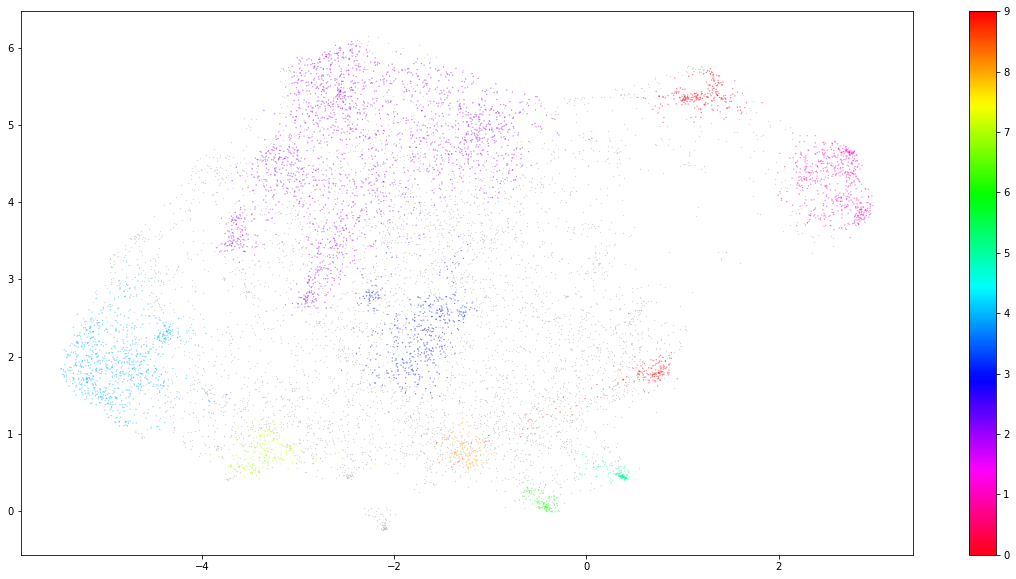

In [10]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

### c-TF-IDF

In [19]:
docs_df = pd.DataFrame(raw_texts, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [20]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(raw_texts))

In [21]:

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,5188
3,2,2034
5,4,830
2,1,560
4,3,449
1,0,238
8,7,210
10,9,160
9,8,125
6,5,114


In [22]:
for topic in topic_sizes['Topic']:
  if topic == -1:
    continue
  print(str([t[0] for t in top_n_words[topic][:10]]) + '\n')



['trump', 'covid', 'coronavirus', '19', 'people', 'covid19', 'don', 'pandemic', 'just', 'realdonaldtrump']

['cases', 'deaths', 'new', '000', '19', 'covid', 'coronavirus', 'million', 'total', 'covid19']

['good', 'great', 'oh', 'read', 'news', 'just', 'god', 'thread', 'let', 'prayers']

['coronavirus', 'china', 'pandemic', 'vaccine', 'virus', 'news', 'covid', 'new', '19', 'update']

['don', 'just', 'fucking', 'fuck', 'sad', 'holy', 'shit', 'terrible', 'dumbass', 'hell']

['2020', '19', 'covid', 'april', 'week', '00', 'today', 'monday', 'covid19', 'friday']

['thank', 'love', 'great', 'thanks', 'support', 'work', 'people', 'amp', 'team', 'happy']

['19', 'covid', 'vaccine', 'patients', 'vaccines', 'health', 'vaccination', 'healthcare', 'workers', 'covid19']

['covid19', 'enviroklenzairpurifiers', 'operationbreathefreshcleanair', 'borisjohnson', 'nytimes', 'narendramodi', 'realdonaldtrump', 'dataviz', 'viralvideovlogs', 'pib_india']

['19', 'covid', 'covid19', 'security', 'update', 'soce